In [1]:
# from sklearn.datasets import load_iris
# from sklearn.preprocessing import MinMaxScaler,StandardScaler
# import pandas as pd
# import numpy as np 

# data = load_iris()

# data1 = pd.DataFrame(data= np.c_[data['data'], data['target']],
#                      columns= data['feature_names'] + ['target'])

# def drop_random_data(df, column, n, distribution='uniform', **kwargs):
#     np.random.seed(123)
#     #'uniform', 'standard', 'normal', or 'poisson'. ? 
#     if distribution == 'uniform':
#         low = 0
#         high = df.shape[0] - 1
#         indices = np.random.randint(low, high, size=n)

#     elif distribution == 'standard':
#         # Use a standard normal distribution to generate random indices
#         mean = df[column].mean()
#         std = df[column].std()

#         indices = np.random.normal(loc=mean, scale=std, size=n)
#         # Round the indices to the nearest integer

#         indices = np.rint(indices).astype(int)

#         # Clip the indices to be within the range of valid indices
#         indices = np.clip(indices, 0, df.shape[0] - 1)

#     else:
#         raise ValueError("Invalid distribution: must be 'uniform' or 'standard'.")

#     # Set the specified column values to NaN at the selected indices
#     for each in indices:
#         df.at[each, column] = np.nan

#     return df

# def apply_random_missing_for_all(df,n):
#   for each in df.columns:
#     df = drop_random_data(df, each, n, distribution='uniform')
#   return df

# def apply_normalize(df):
#     # scaler = MinMaxScaler() #StandardNormalize -> 
#     scaler = StandardScaler()
#     for each in df.columns:
#       df[f'{each}'] = scaler.fit_transform(df[[each]])
#     return df

In [2]:
# new_df = apply_random_missing_for_all(data1,10)
# n_df = apply_normalize(new_df)
# n_df

In [3]:
from keras.layers import Input,Dense,Concatenate
from keras.models import Model
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.preprocessing import MinMaxScaler

def build_generator(input_size):
    """Builds and compiles the generator model.

    Args:
        input_size (int): The number of input features.

    Returns:
        A compiled Keras model object.
    """
    # Define input layers
    input_missing = Input(shape=(input_size,))
    input_hints = Input(shape=(input_size,))

    # Define hidden layers
    x = Concatenate()([input_missing, input_hints])
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output_imputed = Dense(input_size, activation='tanh')(x)

    # Define generator model
    generator = Model(inputs=[input_missing, input_hints], outputs=output_imputed)

    # Compile generator model
    generator.compile(loss='binary_crossentropy', optimizer='adam')

    return generator


def build_discriminator(input_size):
    """Builds and compiles the discriminator model.

    Args:
        input_size (int): The number of input features.

    Returns:
        A compiled Keras model object.
    """
    # Define input layer
    input_data = Input(shape=(input_size,))

    # Define hidden layers
    x = Dense(256, activation='relu')(input_data)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    output_prob = Dense(1, activation='sigmoid')(x)

    # Define discriminator model
    discriminator = Model(inputs=input_data, outputs=output_prob)

    # Compile discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    return discriminator


2023-04-07 12:27:16.993122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 12:27:20.251644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 12:27:20.251729: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 12:27:24.288600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
from keras.losses import mse as mse_loss, binary_crossentropy as bce_loss

def gain_impute(data, hint_probability=0.9, batch_size=64, epochs=10000):
    # Convert input data to NumPy array
    tmp = data.columns
    data = data.values.astype('float32')

    # Create mask of missing values
    mask = np.isnan(data)
    # mask = data.isna().to_numpy()

    # Create generator and discriminator models
    generator = build_generator(data.shape[1])
    discriminator = build_discriminator(data.shape[1])

    # Compile discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    # Create scaler object for data scaling and unscaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data)

    # Scale data to range [-1, 1]
    data_scaled = scaler.transform(data)

    # Train generator and discriminator models
    for epoch in range(epochs):
        # Create batches of observed and missing data
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        for i in range(0, data.shape[0], batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_missing = data_scaled[batch_indices] * mask[batch_indices]
            batch_observed = data_scaled[batch_indices] * (1 - mask[batch_indices])
            batch_hints = None
            batch_hints = (np.random.random(batch_missing.shape) < hint_probability).astype('float32')
            batch_hints = tf.cast(batch_hints, tf.float32)
            # print(batch_hints.dtype)
            
            # Generate fake data using generator model
            #print('-----------',batch_missing,'========',batch_hints)
            fake_data = generator.predict([batch_missing, batch_hints])
            data_hints = batch_missing * (1 - batch_hints) + fake_data * batch_hints
            
            # Train discriminator model
            discriminator.train_on_batch(batch_observed, np.ones((len(batch_observed), 1)))
            discriminator.train_on_batch(fake_data, np.zeros((len(fake_data), 1)))
            discriminator.train_on_batch(data_hints, batch_hints)

            # Train generator model
            gen_loss = 0.5 * mse_loss(batch_hints * fake_data,batch_hints * data_scaled[batch_indices]) + \
                       0.5 * mse_loss((1 - batch_hints) * fake_data, (1 - batch_hints) * batch_observed) + \
                       0.5 * bce_loss(discriminator(data_hints), tf.cast(batch_hints, dtype='float32'))
            generator.train_on_batch([batch_missing, batch_hints], batch_observed)
            
            # Test the generator model by generating some data
            test_missing = np.zeros((10, data.shape[1]), dtype='float32')
            test_hints = np.ones((10, data.shape[1]), dtype='float32')
            test_data = generator.predict([test_missing, test_hints])
            #print(test_data)
            
    # Generate imputed data using generator model
    imputed_data = generator.predict([data_scaled * mask, np.ones_like(data_scaled)])
    #print([data_scaled * mask])
    #print(imputed_data)
    # Unscale imputed data to original range
    imputed_data = scaler.inverse_transform(imputed_data)

    # Fill in missing values with imputed data
    data_filled = data.copy()
    data_filled[mask] = imputed_data[mask]
    data_filled = np.nan_to_num(data_filled, nan=data_filled.mean())
    data[mask] = imputed_data[mask]
    data = np.nan_to_num(data, nan=data.mean())

    # Convert imputed data to pandas DataFrame
    imputed_df = pd.DataFrame(data_filled, columns=tmp)
    
    # Assuming 'generator' is the generator model object
    generator_weights = generator.get_weights()
    #rint('------------------',generator_weights)

    return imputed_df,generator


In [5]:
# data1

In [6]:
# import warnings
# warnings.filterwarnings("ignore")
# imputed_data, model = gain_impute(n_df, hint_probability=0.1, batch_size=128,epochs=20)

In [7]:
# imputed_data

In [8]:
# def fill_nan(df):
#     for i in range(len(df)):
#         if df.loc[i].isna().any() == True:
#             index = np.where(df.loc[i].isna()==True)[0]
#             for each in index:
#                 df.loc[i][each] = 0
#             for each in index : 
#                 scaler = MinMaxScaler(feature_range=(-1, 1))
#                 scaler.fit(data1)
#                 df.loc[i][each] = 0
#                 new_data = pd.DataFrame(data=[df.loc[i]], columns = df.columns)

#                 # Fill in missing value with the mean of the same column
#                 new_data = new_data.fillna(new_data.mean())

#                 new_data_scaled = scaler.transform(new_data.values)
#                 hints = (np.random.random(new_data_scaled.shape) < 0.9).astype('float32')
#                 imputed_data_scaled = model.predict([new_data_scaled, hints])
#                 imputed_data = scaler.inverse_transform(imputed_data_scaled)

#                 df.loc[i][each] = imputed_data[0][each]
#                 print(imputed_data[0][each])
#         else:
#             break 
#     return df

In [9]:
# n_df_imputed = fill_nan(n_df)

In [10]:
# n_df_imputed

In [11]:
# import seaborn as sns
# import pandas as pd

# corr_matrix = imputed_data.corr()
# sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

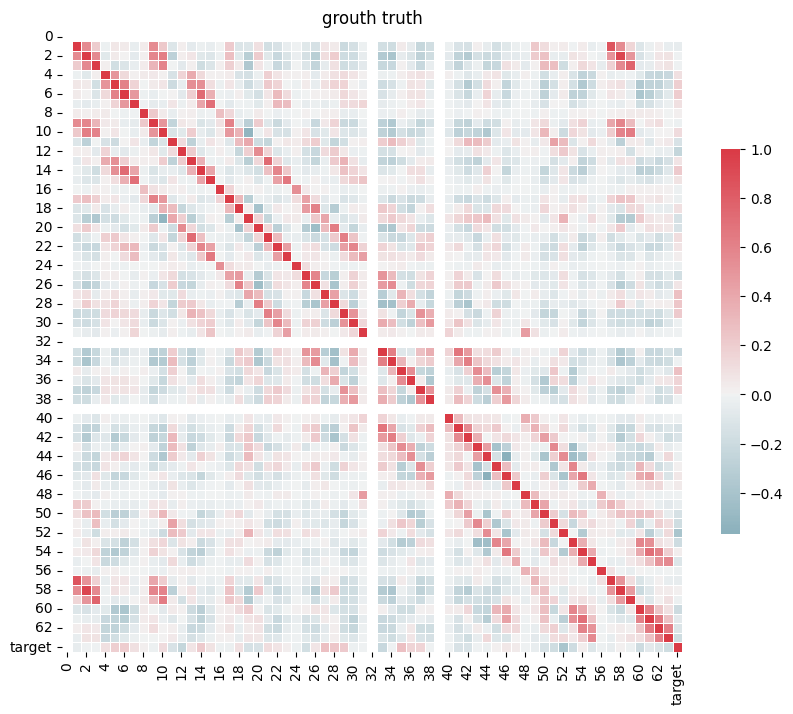

In [13]:
# Load the digit dataset
digits = load_digits()

# Create a dataframe from the digits data
df = pd.DataFrame(digits.data)
df['target'] = digits.target
# Compute the correlation matrix
corr_gt = df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_gt, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("grouth truth")
plt.show()

In [14]:
def randomly_missing_img(data,perc,Type='randomly'):
    '''
    perc : percent of each img -> missing pixel / features
    '''
    result = data.copy()
    def add_noise_to_image(image, p=0.1):
        """
        Adds random noise to an image by randomly replacing some pixels with NaN.

        Args:
            image (ndarray): The input image to add noise to.
            p (float): The probability of replacing each pixel with NaN.

        Returns:
            ndarray: The image with added noise.
        """
        # Copy the input image to avoid modifying the original array
        noisy_image = np.copy(image)

        # Create a mask of the same shape as the input image
        mask = np.random.uniform(size=image.shape)

        # Replace some pixels in the mask with NaN based on the probability p
        mask[mask < p] = np.nan

        # Apply the mask to the input image to create the noisy image
        noisy_image = noisy_image * mask

        return noisy_image

    for i in range(len(data)):
        if Type=='randomly':
            result.iloc[i] = add_noise_to_image(data.iloc[i],p=perc)
    
    return result

In [15]:
new_df = randomly_missing_img(df,perc=0.3)
new_df.shape

(1797, 65)

In [16]:
new_df['target'] = digits.target

In [17]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def apply_normalize(df):
    output = df.copy()
    # scaler = MinMaxScaler() #StandardNormalize -> 
    scaler = StandardScaler()
    for each in output.columns:
      output[each] = scaler.fit_transform(output[[each]])
    return output

In [18]:
new_df = apply_normalize(new_df)

In [19]:
imputed_data, model = gain_impute(new_df, hint_probability=0.1, batch_size=128,epochs=20)

2023-04-07 12:27:40.303203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-07 12:27:40.303819: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 12:27:40.303855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hp): /proc/driver/nvidia/version does not exist
2023-04-07 12:27:40.305161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


57/57 [==============================] - 0s 3ms/step


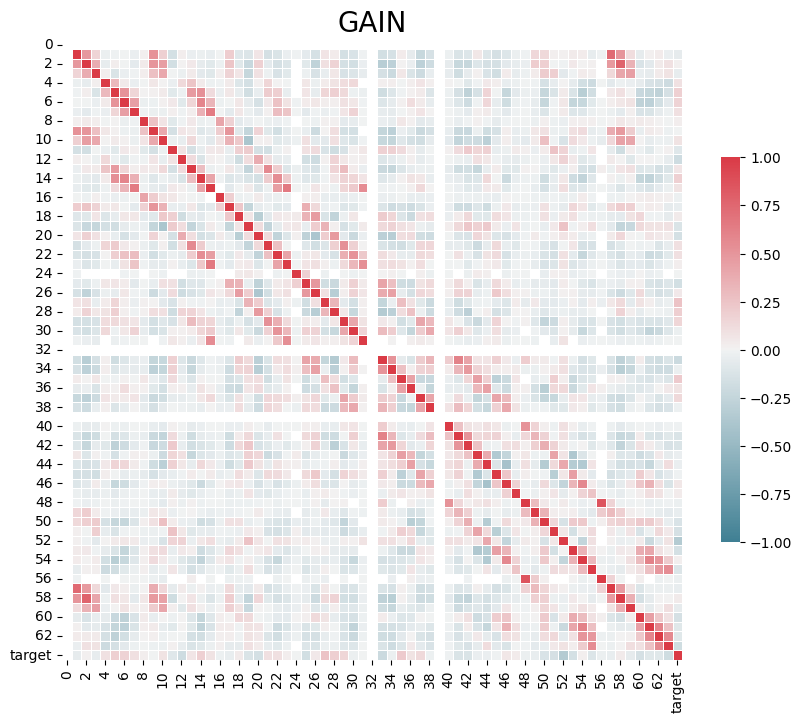

In [20]:
corr_gain = imputed_data.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_gain, cmap=cmap, vmin = -1,center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("GAIN", fontsize=20)
ax.set_xlabel("") # remove the x-axis label
ax.set_ylabel("") # remove the y-axis label
plt.savefig('GAIN.jpg',dpi=1200)
plt.show()

In [21]:
def covariance_rmse(cov_matrix1, cov_matrix2):
    # Convert covariance matrices to correlation matrices
    std1 = np.sqrt(np.diag(cov_matrix1))
    corr_matrix1 = cov_matrix1 / np.outer(std1, std1)

    std2 = np.sqrt(np.diag(cov_matrix2))
    corr_matrix2 = cov_matrix2 / np.outer(std2, std2)

    # Calculate the difference between the two correlation matrices
    diff = corr_matrix1 - corr_matrix2

    # Square each element in the difference matrix
    squared_diff = np.square(diff)

    # Take the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Take the square root of the mean squared difference to get the RMSE
    rmse = np.sqrt(mean_squared_diff)

    # Check if any elements in rmse are NaN
    nan_mask = np.isnan(rmse)
    if np.any(nan_mask):
        # Remove NaN elements from rmse and print a message
        nan_indices = np.where(nan_mask)[0]
        print(f"Elements {nan_indices} are NaN and will be removed.")
        rmse = rmse[~nan_mask]

    total_rmse = (1/len(rmse)) * sum(rmse) 
    print("Total : ",total_rmse)
    return rmse

In [22]:
covariance_rmse(corr_gt, corr_gain)

Elements [ 0 32 39] are NaN and will be removed.
Total :  0.047551960350752445


/home/pn7hao/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


1         0.032497
2         0.061138
3         0.079206
4         0.051430
5         0.048108
            ...   
60        0.065948
61        0.043463
62        0.037159
63        0.024135
target    0.026876
Length: 62, dtype: float64